# Gene Selection via Final Similarity (Embedding Space)

This notebook compares final similarity (cosine) between WT (iteration_0) and
the final iteration for each (model, strategy) using precomputed embeddings.
The goal is to surface genes with **lower similarity** (novel sequences) while
still allowing you to judge whether they look functional.


In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
BASE_DIR = Path.cwd()
if BASE_DIR.name == 'dna-fm-to-alphagenome':
    BASE_DIR = BASE_DIR.parent

EMBED_ROOT = BASE_DIR / 'dna-model-collapse' / 'results' / 'embeddings'
GEN_MODELS = ['DNABERT-2', 'NT-v2-500m']

# Use embedding model == generation model by default.
EMBED_BY = {
    'DNABERT-2': 'DNABERT-2',
    'NT-v2-500m': 'NT-v2-500m',
}

STRATEGIES = ['greedy', 'sampling_t0.5', 'sampling_t1.0', 'sampling_t1.5']

# Optionally restrict to a subset of genes
GENE_FILTER = None


In [3]:
def load_embeddings(gen_model, embed_model):
    path = EMBED_ROOT / f'embeddings_{gen_model}__by__{embed_model}.pkl'
    if not path.exists():
        raise FileNotFoundError(f'Missing embeddings: {path}')
    return pickle.loads(path.read_bytes())

def to_vec(x):
    arr = np.asarray(x)
    if arr.ndim == 2 and arr.shape[0] == 1:
        return arr[0]
    return arr.reshape(-1)

def cosine_sim(a, b):
    a = to_vec(a)
    b = to_vec(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return np.nan
    return float(np.dot(a, b) / denom)

def final_similarity_for_gene(gene_block, strategy):
    if strategy not in gene_block:
        return np.nan
    seq_embs = gene_block[strategy]
    if not seq_embs:
        return np.nan
    wt = seq_embs[0]
    final = seq_embs[-1]
    return cosine_sim(wt, final)


In [4]:
records = []

for gen_model in GEN_MODELS:
    embed_model = EMBED_BY[gen_model]
    data = load_embeddings(gen_model, embed_model)

    genes = sorted(data.keys())
    if GENE_FILTER:
        genes = [g for g in genes if g in GENE_FILTER]

    for gene in genes:
        gene_block = data[gene]
        for strategy in STRATEGIES:
            sim = final_similarity_for_gene(gene_block, strategy)
            records.append({
                'gene': gene,
                'gen_model': gen_model,
                'embed_model': embed_model,
                'strategy': strategy,
                'final_similarity': sim,
            })

df = pd.DataFrame(records)
df.sort_values(['gen_model', 'strategy', 'final_similarity'], ascending=[True, True, True]).head(10)


,gene,gen_model,embed_model,strategy,final_similarity
8,GAS5,DNABERT-2,DNABERT-2,greedy,0.285996
28,RPS29,DNABERT-2,DNABERT-2,greedy,0.332879
16,HBB,DNABERT-2,DNABERT-2,greedy,0.373136
32,SNHG1,DNABERT-2,DNABERT-2,greedy,0.395449
4,GAPDHP1,DNABERT-2,DNABERT-2,greedy,0.506063
36,TP53,DNABERT-2,DNABERT-2,greedy,0.647000
0,GAPDH,DNABERT-2,DNABERT-2,greedy,0.669303
20,PTEN,DNABERT-2,DNABERT-2,greedy,0.698387
12,H19,DNABERT-2,DNABERT-2,greedy,0.741843
24,PTENP1,DNABERT-2,DNABERT-2,greedy,0.768807


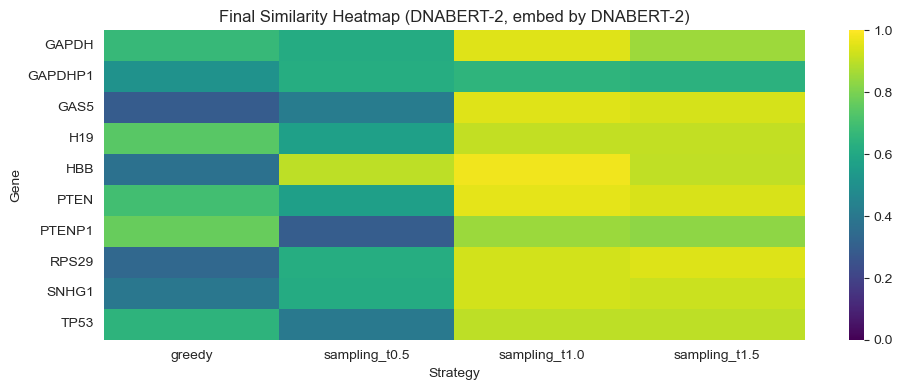

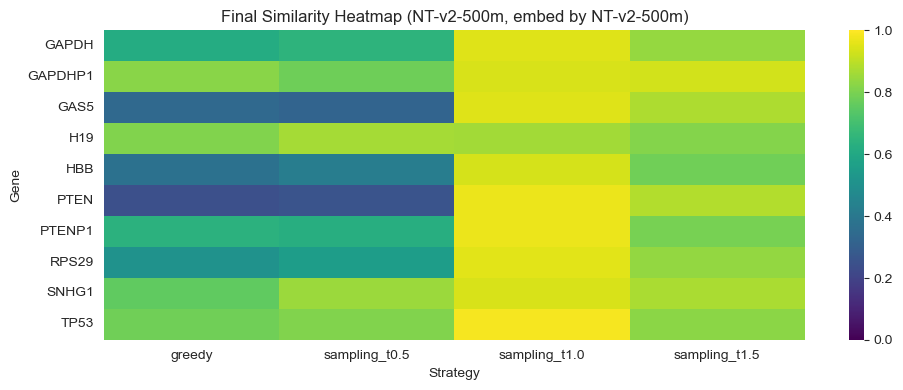

In [5]:
# Heatmap: gene x strategy per model (lower similarity = more novel)
for gen_model in GEN_MODELS:
    sub = df[df['gen_model'] == gen_model]
    pivot = sub.pivot(index='gene', columns='strategy', values='final_similarity')
    plt.figure(figsize=(10, max(4, 0.3 * len(pivot))))
    sns.heatmap(pivot, cmap='viridis', vmin=0.0, vmax=1.0, annot=False)
    plt.title(f'Final Similarity Heatmap ({gen_model}, embed by {EMBED_BY[gen_model]})')
    plt.xlabel('Strategy')
    plt.ylabel('Gene')
    plt.tight_layout()
    plt.show()


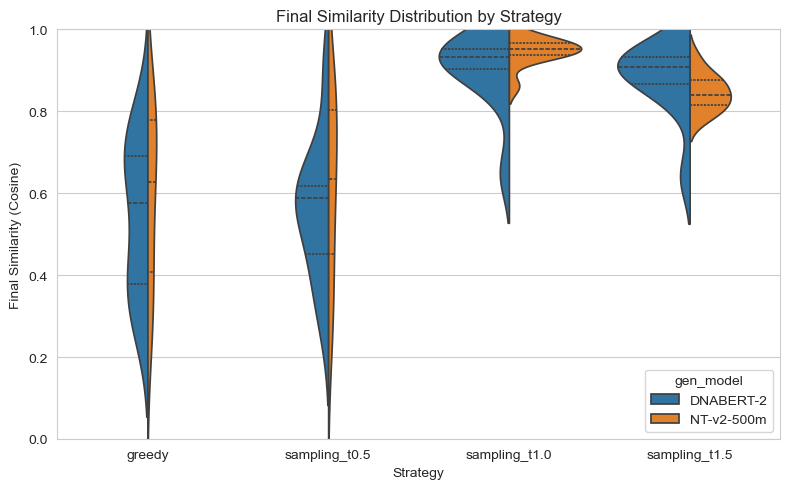

In [6]:
# Distribution view: strategy-wise similarity across genes
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x='strategy',
    y='final_similarity',
    hue='gen_model',
    split=True,
    inner='quartile'
)
plt.title('Final Similarity Distribution by Strategy')
plt.ylabel('Final Similarity (Cosine)')
plt.xlabel('Strategy')
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


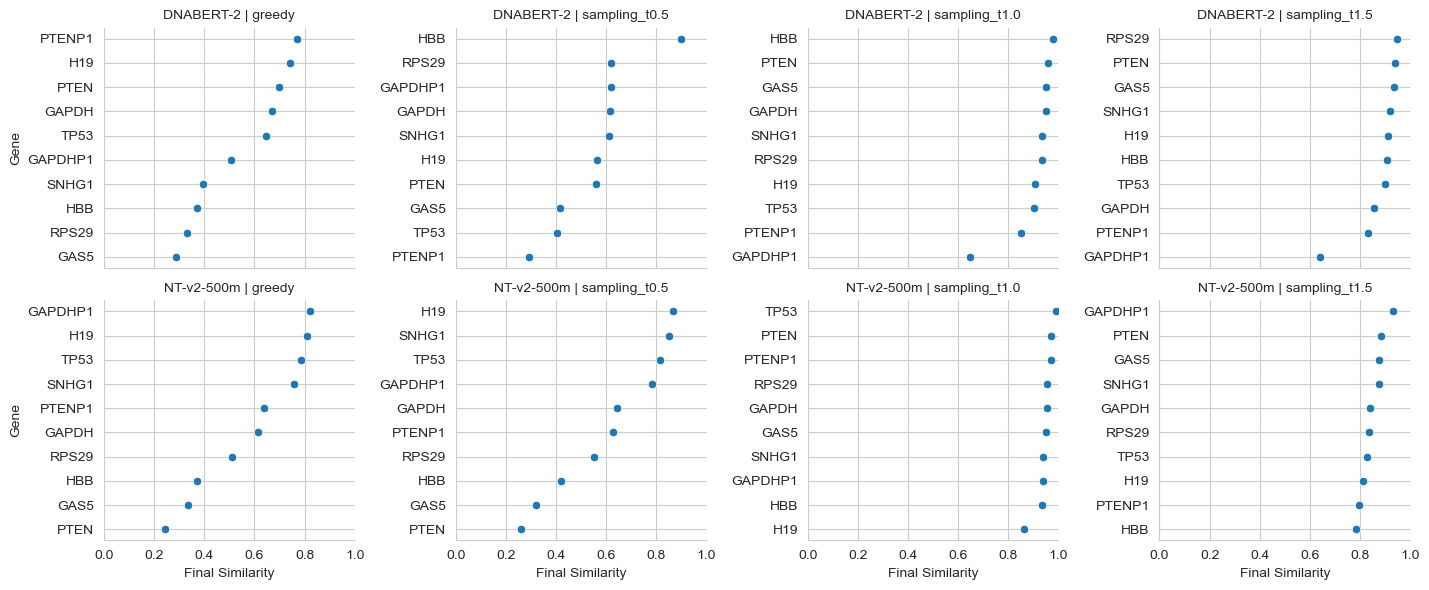

In [7]:
# Ranked view: for each (model, strategy), show highest-similarity genes
TOP_K = 10
ranked = (
    df.sort_values(['gen_model', 'strategy', 'final_similarity'], ascending=[True, True, False])
      .groupby(['gen_model', 'strategy'])
      .head(TOP_K)
)

g = sns.FacetGrid(
    ranked,
    row='gen_model',
    col='strategy',
    sharex=True,
    sharey=False,
    height=3,
    aspect=1.2
)
g.map_dataframe(sns.scatterplot, x='final_similarity', y='gene')
g.set_titles('{row_name} | {col_name}')
g.set_axis_labels('Final Similarity', 'Gene')
for ax in g.axes.flat:
    ax.set_xlim(0.0, 1.0)
plt.tight_layout()
plt.show()


In [8]:
# Compare similarity agreement between models (sampling_t1.0)
STRATEGY_COMPARE = 'sampling_t1.0'

wide = df[df['strategy'] == STRATEGY_COMPARE].pivot_table(
    index='gene',
    columns='gen_model',
    values='final_similarity'
)

# Keep genes present in both models
wide = wide.dropna()
wide['abs_diff'] = (wide['DNABERT-2'] - wide['NT-v2-500m']).abs()

wide_sorted = wide.sort_values('abs_diff')
wide_sorted[['DNABERT-2', 'NT-v2-500m', 'abs_diff']].head(20)


gen_model,DNABERT-2,NT-v2-500m,abs_diff
gene,,,
GAS5,0.952136,0.952229,0.000093
GAPDH,0.950485,0.952794,0.002309
SNHG1,0.932688,0.939294,0.006606
PTEN,0.957158,0.970831,0.013673
RPS29,0.932678,0.955689,0.023010
HBB,0.977765,0.936169,0.041597
H19,0.906827,0.862007,0.044819
TP53,0.901281,0.988236,0.086955
PTENP1,0.849156,0.970548,0.121393


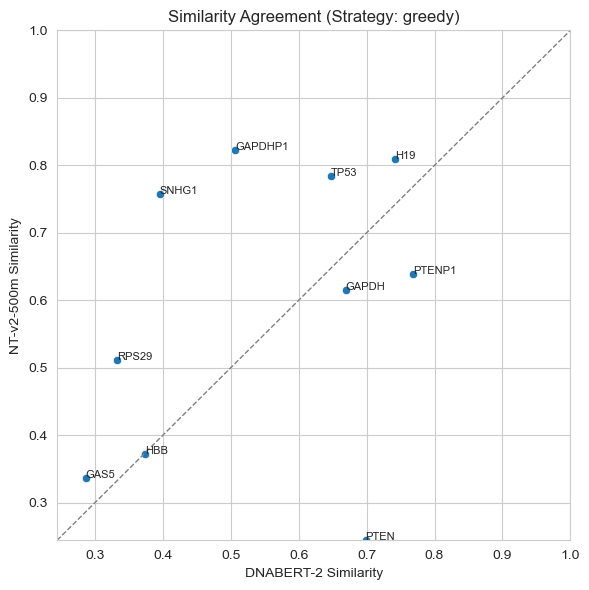

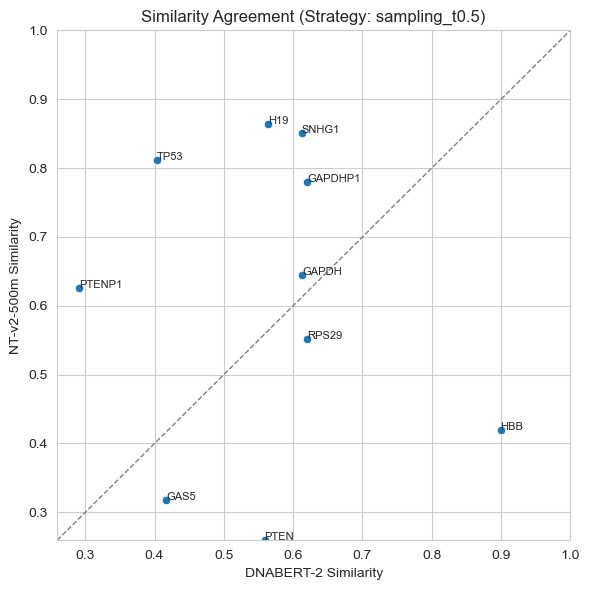

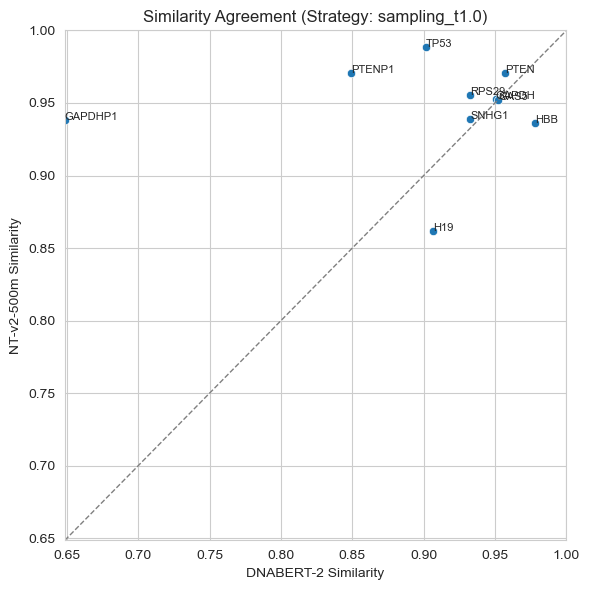

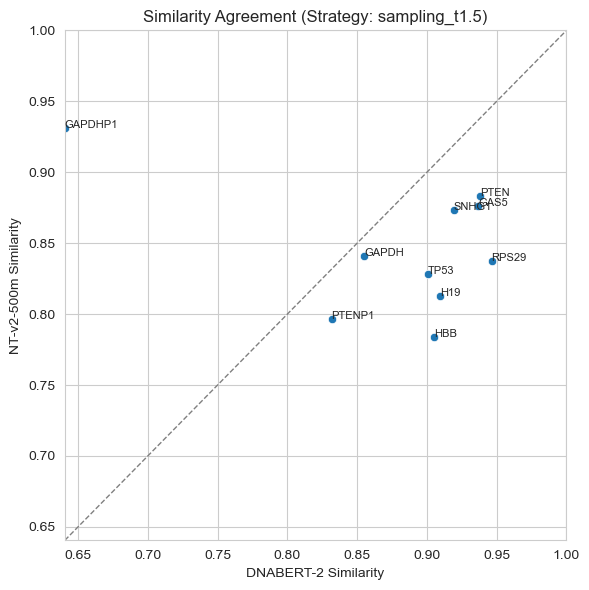

In [9]:
# Scatter plot: DNABERT-2 vs NT-v2-500m similarity per strategy
strategies_to_plot = STRATEGIES

for strat in strategies_to_plot:
    wide = df[df['strategy'] == strat].pivot_table(
        index='gene',
        columns='gen_model',
        values='final_similarity'
    )
    wide = wide.dropna()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=wide,
        x='DNABERT-2',
        y='NT-v2-500m',
    )

    # annotate all genes
    for gene, row in wide.iterrows():
        plt.text(row['DNABERT-2'], row['NT-v2-500m'], gene, fontsize=8)

    min_val = np.nanmin(wide[['DNABERT-2', 'NT-v2-500m']].values)
    plt.plot([min_val, 1.0], [min_val, 1.0], color='gray', linestyle='--', linewidth=1)
    plt.xlabel('DNABERT-2 Similarity')
    plt.ylabel('NT-v2-500m Similarity')
    plt.title(f'Similarity Agreement (Strategy: {strat})')
    plt.xlim(min_val, 1.0)
    plt.ylim(min_val, 1.0)
    plt.tight_layout()
    plt.show()


In [10]:
# Export a summary table for manual inspection
summary = df.pivot_table(
    index=['gene'],
    columns=['gen_model', 'strategy'],
    values='final_similarity'
)
summary


gen_model DNABERT-2                                           NT-v2-500m  \
strategy     greedy sampling_t0.5 sampling_t1.0 sampling_t1.5     greedy   
gene                                                                       
GAPDH      0.669303      0.613125      0.950485      0.855271   0.615504   
GAPDHP1    0.506063      0.619885      0.648605      0.640535   0.821953   
GAS5       0.285996      0.416615      0.952136      0.936802   0.336294   
H19        0.741843      0.564279      0.906827      0.909591   0.810024   
HBB        0.373136      0.899360      0.977765      0.905187   0.371931   
PTEN       0.698387      0.558723      0.957158      0.938070   0.243979   
PTENP1     0.768807      0.291187      0.849156      0.831702   0.638795   
RPS29      0.332879      0.620481      0.932678      0.946337   0.511580   
SNHG1      0.395449      0.612118      0.932688      0.919186   0.757400   
TP53       0.647000      0.403682      0.901281      0.900940   0.784453   

gen_model                                            
strategy  sampling_t0.5 sampling_t1.0 sampling_t1.5  
gene                                                 
GAPDH          0.644609      0.952794      0.840920  
GAPDHP1        0.780514      0.938087      0.930883  
GAS5           0.318155      0.952229      0.876156  
H19            0.864265      0.862007      0.812615  
HBB            0.419103      0.936169      0.783942  
PTEN           0.259369      0.970831      0.883273  
PTENP1         0.625802      0.970548      0.796552  
RPS29          0.551934      0.955689      0.837259  
SNHG1          0.851348      0.939294      0.873548  
TP53           0.812380      0.988236      0.828110